# Results and Issues
Covered in this notebook:
1. Obtain near-identical results to Ramirez's.
2. Highlight key issues impacting presented results.
    a. Problematic bet impacting results.
    b. Incorrect kelly criterion.

In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import econtools.metrics as mt
import numpy as np
from econtools import read, outreg, table_statrow, write_notes
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('seaborn-v0_8-deep')

In [2]:
original_df = pd.read_csv(r'C:\Users\faxul\Google Drive\RamirezRepStudy\thesisminusdata\TradeCode\paper_repstudy\notFeelingTheBuzz\Datafiles\Ramirez_matches_cleaned.csv')
fitset = original_df[~(original_df['date'] > '2019-01-00')].copy()
testset = original_df[(original_df['date'] > '2019-01-00')].copy()

testset.reset_index(inplace=True)
print('Fit set rows: '+str(len(fitset)))
print('Test set rows: '+str(len(testset)))

Fit set rows: 15854
Test set rows: 5190


In [4]:
testset

,index,Unnamed: 0,match_id,player,date,year,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome
0,15854,1981,1981,Petra Kvitova,2019-01-01,2019.0,-0.115079,-0.214383,0.833333,0.806452,0.781250,1
1,15855,1980,1980,Veronika Kudermetova,2019-01-01,2019.0,0.016291,1.875280,0.266667,0.257069,0.226757,1
2,15856,1979,1979,Johanna Konta,2019-01-01,2019.0,0.139640,0.195659,0.500000,0.476190,0.454545,1
3,15857,1988,1988,Anastasija Sevastova,2019-01-01,2019.0,-0.062338,-0.923888,0.714286,0.694444,0.666667,1
4,15858,1977,1977,Su-Wei Hsieh,2019-01-01,2019.0,-0.023950,0.310155,0.666667,0.645161,0.613497,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5185,21039,4139,4139,Ekaterina Alexandrova,2020-02-15,2020.0,0.089286,1.323982,0.500000,0.483092,0.454545,0
5186,21040,4139,4139,Kiki Bertens,2020-02-15,2020.0,-0.089286,-1.323982,0.555556,0.571429,0.526316,1
5187,21041,4142,4142,Maria Sakkari,2020-02-15,2020.0,-0.007619,-1.612937,0.421941,0.431034,0.408163,0
5188,21042,4143,4143,Kiki Bertens,2020-02-16,2020.0,-0.085000,-2.935837,0.636943,0.641026,0.621118,1


In [5]:
testset[testset["inverse_best"].isna()]

,index,Unnamed: 0,match_id,player,date,year,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome
2871,18725,13918,13918,Kristina Kucova,2019-07-15,2019.0,0.007736,0.395896,0.4,0.398406,NaN,0


In [32]:
def fit_regression(rankdist: bool = True):
    if rankdist:
        results = mt.reg(fitset,'outcome',                      
        ['inverse_avg', 'rankdist', 'wikibuzz'],
        #fe_name= "year",
        cluster='match_id',addcons=True
        )
        params = [results.beta[-1], results.beta[0], results.beta[1], results.beta[2]]
        #params= [constant        , inverse_avg    , rankdist       , wikibuzz       ]
        print(results)
    else:
        # No RankDist variable
        results = mt.reg(fitset,'outcome',
        ['inverse_avg', 'wikibuzz'],
        #fe_name= "year",
        cluster='match_id',addcons=True
        )
        params = [results.beta[-1], results.beta[0], results.beta[1]]
        print(results)
    return params

def estimate_probability(params: pd.Series,
                         inverse_odds: float,
                         rankdist: float = None,
                         wikibuzz: float = None) -> float:
    if (rankdist is not None) & (wikibuzz is not None):
        y_hat = params[0] + params[-3]*inverse_odds + params[-2]*rankdist + params[-1]*wikibuzz
    if (rankdist is not None) & (wikibuzz is None):
        y_hat = params[0] + params[-2] * inverse_odds + params[-1] * rankdist
    if (wikibuzz is not None) & (rankdist is None):
        y_hat = params[0] + params[-2]*inverse_odds + params[-1]*wikibuzz
    return y_hat

def kelly_criterion(odds_implied_prob, y_hat):
    odds = 1/odds_implied_prob
    k = max(y_hat - ((1 - y_hat)/(odds - 1)), 0)
    return k

def profit_loss(kelly, odds_implied_prob, outcome):
    odds = 1 / odds_implied_prob
    if outcome == 1:
        PnL = kelly*odds - kelly
    if outcome == 0:
        PnL = -kelly
    return PnL

def show_results(testset, params, odds, rankdist: bool = True): # Odds = "avg", "best", "b365"

    # Estimate Probability.
    if rankdist:
        testset['model_est_prob'] = [estimate_probability(params, row[0], row[1], row[2]) for row in zip(testset['inverse_avg'],
                                                                                                         testset['rankdist'],
                                                                                                         testset['wikibuzz'])]
    else:
        testset['model_est_prob'] = [estimate_probability(params, inverse_odds=row[0], wikibuzz=row[1]) for row in zip(testset['inverse_avg'],
                                                                                                                       testset['wikibuzz'])]
    # Determine kelly bet size.
    testset['kelly_betsize'] = [kelly_criterion(row[0], row[1]) for row in zip(testset['inverse_{}'.format(odds)],
                                                                               testset['model_est_prob'])]
    # Calculate return for the bet.
    testset['PnL'] = [profit_loss(row[0], row[1], row[2]) for row in zip(testset['kelly_betsize'],testset['inverse_{}'.format(odds)],
                                                                         testset['outcome'])]

    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print('Absolute return: '+str(testset['PnL'].sum()))
    print('Absolute amount bet: '+str(testset['kelly_betsize'].sum()))
    print('ROI (%): '+str((((testset['PnL'].sum() + testset['kelly_betsize'].sum())/testset['kelly_betsize'].sum())-1)*100))

def plot_results():
    testset['Cum_PnL'] = testset['PnL'].cumsum() * 100
    plt.rcParams.update({'font.size': 13})
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    testset.plot('date', 'Cum_PnL', ax=ax, linewidth=1.5)
    
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    
    ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey').set_linewidth(1.2)
    
    plt.show()
    
def correct_kelly_results(odds, rankdist: bool = True): # Odds = "avg", "best", "b365"
    
    if rankdist == True:
        params = fit_regression(rankdist=True)
    else:
        params = fit_regression(rankdist=False)
    show_results(testset, params, odds, rankdist)
    
    testset['bankroll_after'] = testset['PnL'] + 1
    testset['bankroll_after'] = testset['bankroll_after'].cumprod()
    testset['bankroll_before'] = testset.bankroll_after.shift(1)
    testset['betsize_of_inital_bankroll'] = testset['kelly_betsize'] * testset['bankroll_before']
    testset['pnl_of_initial_bankroll'] = testset['PnL'] * testset['bankroll_before']
    print("---------------")
    print("*Correct Kelly*")
    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print('Absolute return: ' + str(testset['pnl_of_initial_bankroll'].sum()))
    print('Absolute amount bet: ' + str(testset['betsize_of_inital_bankroll'].sum()))
    print('ROI (%): ' + str((((testset['pnl_of_initial_bankroll'].sum() + testset['betsize_of_inital_bankroll'].sum()) / testset[
    'betsize_of_inital_bankroll'].sum()) - 1)*100))

## 1. Obtain near-identical results to Ramirez.

Dependent variable:	outcome
N:			15854
R-squared:		0.1589
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.025 0.028 36.945 0.000  0.971   1.080
rankdist     0.055 0.031  1.787 0.074 -0.005   0.115
wikibuzz     0.009 0.004  2.117 0.034  0.001   0.017
_cons       -0.041 0.015 -2.831 0.005 -0.070  -0.013

Bets considered (2 * Matches): 5156
Number of bets placed: 312
Mean overround (%): 6.456499124919013
Absolute return: 1.2360930817859561
Absolute amount bet: 7.151004389194103
ROI (%): 17.285586954104225


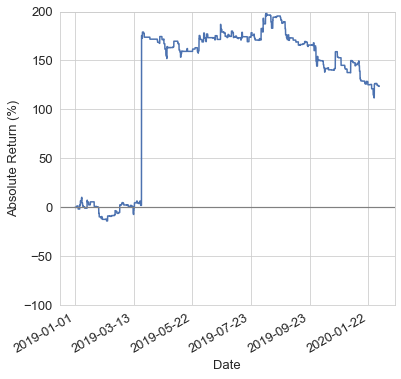

In [33]:
params = fit_regression(rankdist=True)
show_results(testset, params=params, odds="b365", rankdist=True)
plot_results()

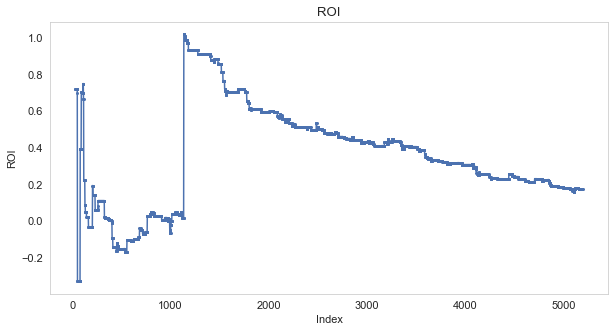

In [26]:
testset['ROI'] = (testset['PnL'].cumsum() + testset['kelly_betsize'].cumsum()) / testset['kelly_betsize'].cumsum()
testset['ROI'] = testset['ROI'] - 1
# Plot the Cumulative_ROI
plt.figure(figsize=(10, 5))
plt.plot(testset['ROI'], marker='o', markersize=2)
plt.xlabel('Index')
plt.ylabel('ROI')
plt.title('ROI')
plt.grid()
plt.show()

In [29]:
testset[testset['inverse_b365'] < testset['inverse_best']]

,index,Unnamed: 0,match_id,player,date,year,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome,model_est_prob,kelly_betsize,PnL,Cum_PnL,ROI
1118,16972,5869,5869,Katerina Siniakova,2019-03-22,2019.0,0.059524,0.380055,0.454545,0.471698,0.454545,0,0.448749,0.000000,-0.000000,6.291431,0.048642
1135,16989,5883,5883,Polona Hercog,2019-03-23,2019.0,-0.001824,-1.707411,0.181818,0.540541,0.476190,1,0.497091,0.385334,1.734001,175.411390,1.018911
1569,17423,7640,7640,Anett Kontaveit,2019-04-27,2019.0,0.933333,2.117202,0.454545,0.469484,0.462963,1,0.509978,0.101627,0.121952,164.179351,0.711826
2102,17956,10078,10078,Viktorija Golubic,2019-05-27,2019.0,0.027342,0.875469,0.312500,0.342466,0.312500,0,0.318988,0.009437,-0.009437,157.480295,0.561895
2886,18740,13921,13921,Shilin Xu,2019-07-16,2019.0,0.001536,-0.042560,0.333333,0.337838,0.338983,0,0.304531,0.000000,-0.000000,174.273822,0.441672
2908,18762,13923,13923,Stefanie Voegele,2019-07-16,2019.0,0.009332,1.098612,0.400000,0.413223,0.409836,0,0.392556,0.000000,-0.000000,174.273822,0.441672
2925,18779,13945,13945,Ysaline Bonaventure,2019-07-17,2019.0,0.002098,0.579818,0.454545,0.460829,0.454545,0,0.436272,0.000000,-0.000000,174.273822,0.441672
2965,18819,13969,13969,Patricia Maria Tig,2019-07-21,2019.0,0.009434,-1.854343,0.421941,0.429185,0.425532,0,0.382224,0.000000,-0.000000,169.253269,0.423362
3593,19447,16147,16147,Alize Cornet,2019-08-29,2019.0,0.067708,-0.351280,0.312500,0.333333,0.312500,0,0.300742,0.000000,-0.000000,176.213962,0.349698
4109,19963,18350,18350,Sofia Kenin,2019-09-25,2019.0,0.941176,0.787290,0.312500,0.335570,0.312500,0,0.361104,0.070697,-0.070697,155.468129,0.275774


Dependent variable:	outcome
N:			15854
R-squared:		0.1586
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.005 0.025 39.826 0.000  0.956   1.055
wikibuzz     0.010 0.004  2.265 0.024  0.001   0.018
_cons       -0.031 0.013 -2.323 0.020 -0.057  -0.005

Bets considered (2 * Matches): 5156
Number of bets placed: 276
Mean overround (%): 6.456499124919013
Absolute return: 1.4372911056209992
Absolute amount bet: 4.987843280940591
ROI (%): 28.81588343228698


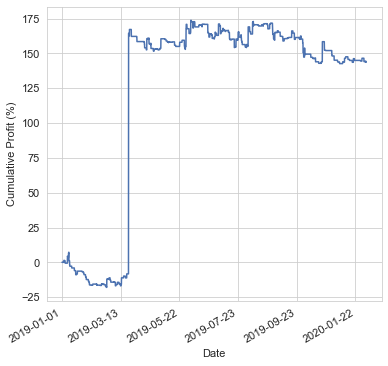

In [53]:
params = fit_regression(rankdist=False)
show_results(testset, params=params, odds="b365", rankdist=False)
plot_results()

Dependent variable:	outcome
N:			15854
R-squared:		0.1586
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.005 0.025 39.826 0.000  0.956   1.055
wikibuzz     0.010 0.004  2.265 0.024  0.001   0.018
_cons       -0.031 0.013 -2.323 0.020 -0.057  -0.005

Bets considered (2 * Matches): 5189
Number of bets placed: 2351
Mean overround (%): -0.22770090708685853
Absolute return: 1.682435509137353
Absolute amount bet: 70.4381749807251
ROI (%): 2.3885279673951487


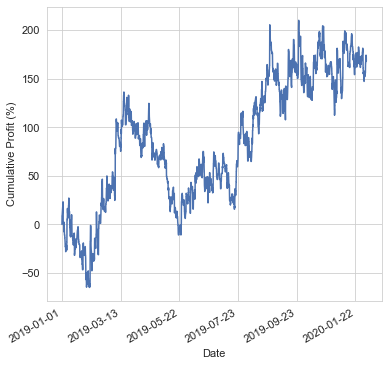

In [8]:
params = fit_regression(rankdist=False)
show_results(testset, params=params, odds="best", rankdist=False)
plot_results()

In [22]:
testset = testset[testset["match_id"] != 13918]

## 2.  Bet365 results skewed by profitable bet.

In [16]:
show_results(testset, params=params, odds="b365", rankdist=True)
testset.sort_values(by=["PnL"], ascending=False).head()

Bets considered (2 * Matches): 5156
Number of bets placed: 312
Mean overround (%): 6.456499124919013
Absolute return: 1.2360930817859561
Absolute amount bet: 7.151004389194103
ROI (%): 17.285586954104225


,index,Unnamed: 0,match_id,player,date,year,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome,model_est_prob,kelly_betsize,PnL,Cum_PnL,ROI,Cumulative_ROI
1135,16989,5883,5883,Polona Hercog,2019-03-23,2019.0,-0.001824,-1.707411,0.181818,0.540541,0.476190,1,0.497091,0.385334,1.734001,175.411390,1.018911,3.107266
4439,20293,20000,20000,Veronika Kudermetova,2019-10-17,2019.0,0.226190,1.707976,0.307692,0.364964,0.307692,1,0.360454,0.076212,0.171476,158.813457,0.254892,24390.964863
2482,18336,12033,12033,Yulia Putintseva,2019-06-20,2019.0,0.976744,1.032863,0.266667,0.279330,0.250000,1,0.307616,0.055840,0.153559,186.870823,0.533477,-30.196696
5104,20958,2540,2540,Sofia Kenin,2020-01-30,2020.0,0.933333,1.061726,0.266667,0.277778,0.248139,1,0.303912,0.050789,0.139668,125.830934,0.176759,-4260.229908
3209,19063,15953,15953,Sofia Kenin,2019-08-06,2019.0,0.965517,0.797335,0.230947,0.238663,0.217391,1,0.263184,0.041918,0.139587,193.082474,0.447508,22512.515222


In [17]:
# Remove bet...
testset.drop(index=1135, inplace=True)
# Then rerun all results above to see changes!

## 3. Incorrect kelly.
A Kelly criterion conventionally determines the bet size in respect to bankroll at the time of the bet, not the bankroll from the start of the test period.




In [38]:
correct_kelly_results("best", rankdist=True)

Dependent variable:	outcome
N:			15854
R-squared:		0.1589
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.025 0.028 36.945 0.000  0.971   1.080
rankdist     0.055 0.031  1.787 0.074 -0.005   0.115
wikibuzz     0.009 0.004  2.117 0.034  0.001   0.017
_cons       -0.041 0.015 -2.831 0.005 -0.070  -0.013

Bets considered (2 * Matches): 5189
Number of bets placed: 2350
Mean overround (%): -0.22770090708685853
Absolute return: 2.340716517895823
Absolute amount bet: 76.62824688935419
ROI (%): 3.0546392654338783
---------------
*Correct Kelly*
Bets considered (2 * Matches): 5189
Number of bets placed: 2350
Mean overround (%): -0.22770090708685853
Absolute return: -0.2730959482192593
Absolute amount bet: 120.89880524110042
ROI (%): -0.2258880455225709
